In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [5]:
import torch
import torch.nn.functional as F
from torch import nn
device = torch.device('cpu')  # CPU should be fine for this lab
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
from collections import OrderedDict
import numpy as np

# Sentiment Classification 


We are going to augment a sentiment classifier with a layer of discrete latent variables which will help us improve the model's interpretability. But first, let's quickly review the baseline task.


In sentiment classification, we have some text input $x = \langle x_1, \ldots, x_n \rangle$, e.g. a sentence or short paragraph, which expresses a certain sentiment $y$, i.e. one of $K$ classes, towards a subject (e.g. a film or a product). 



We can learn a sentiment classifier by learning a categorical distribution over classes for a given input:

\begin{align}
Y|x &\sim \text{Cat}(f(x; \theta))
\end{align}

where the Categorical pmf is $\text{Cat}(y|\pi) = \pi_y$.

A categorical distribution over $K$ classes is parameterised by a $K$-dimensional probability vector, here we use a neural network $f$ to map from the input to this probability vector. Technically we say *a neural network parameterise our model*, that is, it computes the parameters of our categorical observation model. The figure below is a graphical depiction of the model: circled nodes are random variables (a shaded node is an observed variable), uncircled nodes are deterministic, a plate indicates multiple draws.

<img src="https://github.com/probabll/dgm4nlp/raw/master/notebooks/sst/img/classifier.png"  height="100">

The neural network (NN) $f(\cdot; \theta)$ has parameters of its own, i.e. the weights of the various architecture blocks used, which we denoted generically by $\theta$.

Suppose we have a dataset $\mathcal D = \{(x^{(1)}, y^{(1)}), \ldots, (x^{(N)}, y^{(N)})\}$ containing $N$ i.i.d. observations. Then we can use the log-likelihood function 
\begin{align}
\mathcal L(\theta|\mathcal D) &= \sum_{k=1}^{N} \log P(y^{(k)}|x^{(k)}, \theta) \\
&= \sum_{k=1}^{N} \log \text{Cat}(y^{(k)}|f(x^{(k)}; \theta))
\end{align}
 to estimate $\theta$ by maximisation:
 \begin{align}
 \theta^\star = \arg\max_{\theta \in \Theta} \mathcal L(\theta|\mathcal D) ~ .
 \end{align}
 

We can use stochastic gradient-ascent to find a local optimum of $\mathcal L(\theta|\mathcal D)$, which only requires a gradient estimate:

\begin{align}
\nabla_\theta \mathcal L(\theta|\mathcal D) &= \sum_{k=1}^{|\mathcal D|} \nabla_\theta  \log P(y^{(k)}|x^{(k)}, \theta) \\ 
&= \sum_{k=1}^{|\mathcal D|} \frac{1}{N} N \nabla_\theta  \log P(y^{(k)}|x^{(k)}, \theta)  \\
&= \mathbb E_{\mathcal U(1/N)} \left[ N \nabla_\theta  \log P(y^{(K)}|x^{(K)}, \theta) \right]  \\
&\overset{\text{MC}}{\approx} \frac{N}{M} \sum_{m=1}^M \nabla_\theta  \log P(y^{(k_m)}|x^{(k_m)}, \theta) \\
&\text{where }K_m \sim \mathcal U(1/N)
\end{align}

This is a Monte Carlo (MC) estimate of the gradient computed on $M$ data points selected uniformly at random from $\mathcal D$.

For as long as $f$ remains differentiable wrt to its inputs and parameters, we can rely on automatic differentiation to obtain gradient estimates.

In what follows we show how to design $f$ and how to extend this basic model to a latent-variable model.



## Data

We provide you some code to load the data (see `sst.sstutil.examplereader`). Play with the snippet below and inspect a few training instances:

In [6]:
from sst.sstutil import examplereader, Vocabulary, load_glove


# Let's load the data into memory.
print("Loading data")
train_data = list(examplereader('sst/data/sst/train.txt'))
dev_data = list(examplereader('sst/data/sst/dev.txt'))
test_data = list(examplereader('sst/data/sst/test.txt'))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

print('\n# Examples')
example = dev_data[0]
print("First dev example:", example)
print("First dev example tokens:", example.tokens)
print("First dev example label:", example.label)

Loading data
train 8544
dev 1101
test 2210

# Examples
First dev example: Example(tokens=['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], label=3, transitions=[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], token_labels=[2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2])
First dev example tokens: ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
First dev example label: 3


## Architecture


The function $f$ conditions on a high-dimensional input (i.e. text), so we need to convert it to continuous real vectors. This is the job an *encoder*. 

**Embedding Layer**

The first step is to convert the words in $x$ to vectors, which in this lab we will do with a pre-trained embedding layer (we will use GloVe).

We will denote the embedding of the $i$th word of the input by:

\begin{equation}
\mathbf x_i = \text{glove}(x_i)
\end{equation}

**Encoder Layer**

In this lab, an encoder takes a sequence of input vectors $\mathbf x_1^n$, each $I$-dimensional, and produces a sequence of output vectors $\mathbf t_1^n$, each $O$-dimensional and a summary vector $\mathbf h \in \mathbb R^O$:

\begin{equation}
    \mathbf t_1^n, \mathbf h = \text{encoder}(\mathbf x_1^n; \theta_{\text{enc}})
\end{equation}

where we use $\theta_{\text{enc}}$ to denote the subset of parameters in $\theta$ that are specific to this encoder block. 

*Remark:* in practice for a correct batched implementation, our encoders also take a mask matrix and a vector of lengths.

Examples of encoding functions can be a feed-forward NN (with an aggregator based on sum or average/max pooling) or a recurrent NN (e.g. an LSTM/GRU). Other architectures are also possible.

**Output Layer**

From our summary vector $\mathbf h$, we need to parameterise a categorical distribution over $K$ classes, thus we use

\begin{align}
f(x; \theta) &= \text{softmax}(\text{dense}_K(\mathbf h; \theta_{\text{output}}))
\end{align}

where $\text{dense}_K$ is a dense layer with $K=5$ outputs and $\theta_{\text{output}}$ corresponds to its parameters (weight matrix and bias vector). Note that we need to use the softmax activation function in order to guarantee that the output of $f$ is a normalised probability vector.


## Implementation

To leave an indication of the shape of tensors in the code, we use the following convention

```python
[B, T, D]
```

where `B` stands for `batch_size`, `T` stands for `time` (or rather *maximum sequence length*), and `D` is the size of the representation.


Consider the following abstract Encoder class:

In [7]:
class Encoder(nn.Module):
    """
    An Encoder for us is a function that
      1. transforms a sequence of I-dimensional vectors into a sequence of O-dimensional vectors
      2. summarises a sequence of I-dimensional vectors into one O-dimensional vector
      
    """
    def __init__(self):
        super(Encoder, self).__init__()
        
    def forward(self, inputs, mask, lengths):
        """
        The input is a batch-first tensor of token ids. Here is an example:
        
        Example of inputs (though rather than words, we have word ids):
            INPUTS                     MASK       LENGTHS
            [the nice cat -PAD-]    -> [1 1 1 0]  [3]
            [the nice dog running]  -> [1 1 1 1]  [4]
            
        Note that:
              mask =  inputs == 1
              lengths = mask.sum(dim=-1)
        
        :param inputs: [B, T, I]
        :param mask: [B, T]
        :param lengths: [B]
        :returns: [B, T, O], [B, O]
            where the first tensor is the transformed input
            and the second tensor is a summary of all inputs
        """
        pass
        

Let's start easy, implement a *bag of words* encoder:

In [8]:
class BagOfWordsEncoder(Encoder):
    """
    This encoder does not transform the input sequence, 
     and its summary output is just a sum.
    """
    def __init__(self):
        super(BagOfWordsEncoder, self).__init__()
    
    def forward(self, inputs, mask, lengths):
        return inputs, (inputs * mask.unsqueeze(dim=-1).float()).sum(dim=1)  # sum along time

You can also consider implementing

* a feed-forward encoder with average pooling
* and a biLSTM encoder

but these are certainly optional.

In [0]:
class FFEncoder(Encoder):
    """
    A typical feed-forward NN with tanh hidden activations.
    """
    
    def __init__(self, input_size, output_size,
                 activation=None,
                 hidden_sizes=[],
                 aggregator='avg',
                 dropout=0.5):
        """
        :param input_size: int
        :param output_size: int
        :param hidden_sizes: list of integers (dimensionality of hidden layers)
        :param aggregator: 'sum' or 'avg'
        :param dropout: dropout rate
        """
        if aggregator not in ['avg', 'sum']:
            raise RuntimeError("aggregator param should be 'avg' or 'sum' only")
        self.aggregator = aggregator
        layers = []
        
        def add_dropout_if_possible(idx):
            if dropout > 0:
                layers.append(nn.Dropout(('dropout_{}'.format(idx),
                                          nn.Dropout(dropout))))
        
        for idx, hidden_size in enumerate(hidden_sizes):
            add_dropout_if_possible(idx)
            layers.append(('linear_{}'.format(idx),
                           nn.Linear(input_size, hidden_size)))
            layers.append(('tanh_{}'.format(idx), nn.Tanh()))
            input_size = hidden_size
        add_dropout_if_possible(idx)
        layers.append(('linear_{}'.format(idx),
                       nn.Linear(input_size, output_size)))

        self.layer = nn.Sequential(OrderedDict(layers))
        self.activation = activation
    
    def compute_summary_vector(self, out, mask, lengths):
        # summarize along time
        sum_vec = (out * mask.unsqueeze(dim=-1).float()).sum(dim=1)
        
        if self.aggregator == 'sum':
            return sum_vec
        elif self.aggregator == 'avg':
            return sum_vec / lengths.unsqueeze(dim=-1).float()
        raise RuntimeError("Weird aggregator")

    def forward(self, x, mask, lengths):
        """
        :param x: sequence of word embeddings, shape [B, T, I]
        :param mask: byte mask that is 0 for invalid positions, shape [B, T]
        :param lengths: the lengths of each input sequence [B]
        :return: 
            outputs [B, T, O]
            sum/avg pooling [B, O]
        """
        out = self.activation(self.layer(x))
        summary_out = self.compute_summary_vector(out, mask, lengths)
        return out, summary_out

In [0]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class LSTMEncoder(Encoder):
    """
    This module encodes a sequence using a bidirectional LSTM
     it returns the final state
     and the hidden states at each time step. Note: we concatenate representations
     from the two directions.
    """

    def __init__(self, in_features,
                 hidden_size: int = 200,
                 batch_first: bool = True,
                 bidirectional: bool = True):
        """
        :param in_features:
        :param hidden_size:
        :param batch_first:
        :param bidirectional:
        """
        self.batch_first = batch_first
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_size,
            batch_first=batch_first,
            bidirectional=bidirectional
        )
    
    def compute_summary_vec(self, hx):
        if self.lstm.bidirectional:
            return torch.cat([hx[-2], hx[-1]], dim=-1)
        else:
            return hx[-1]

    def forward(self, x, mask, lengths):
        """
        Encode sentence x
        :param x: sequence of word embeddings, shape [B, T, I]
        :param mask: byte mask that is 0 for invalid positions, shape [B, T]
        :param lengths: the lengths of each input sequence [B]
        :return:
            outputs [B, T, O]
            final state [B, O]
        """
        packed_input = pack_padded_sequence(x, lengths, batch_first=self.batch_first)
        packed_out, (hx, cx) = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=self.batch_first)
        
        summary_out = self.compute_summary_vec(hx)
        
        return out, summary_out

Here is some helper code to select and return an encoder:

In [9]:
def get_encoder(layer, in_features, hidden_size, bidirectional=True):
    """Returns the requested layer."""

    # TODO: make pass and average layers
    if layer == "bow":
        return BagOfWordsEncoder()
    elif layer == 'ff':
        return FFEncoder(
            in_features, 
            2 * hidden_size,  # output_size, for convenience to be equal to lstm
            hidden_sizes=[hidden_size], 
            aggregator='avg')
    elif layer == "lstm":
        return LSTMEncoder(
            in_features, 
            hidden_size,
            bidirectional=bidirectional)
    else:
        raise ValueError("Unknown layer")

# Sentiment Classification with Latent Rationale

A latent rationale is a compact and informative fragment of the input based on which a NN classifier makes its decisions. [Lei et al (2016)](http://aclweb.org/anthology/D16-1011) proposed to induce such rationales along with a regression model for multi-aspect sentiment analsysis, their model is trained via REINFORCE on a dataset of beer reviews.

*Remark:* the model we will develop here can be seen as a probabilistic version of their model. The rest of this notebook focus on our own probabilitisc view of the model.

The picture below depicts our latent-variable model for rationale extraction:

<img src="https://github.com/probabll/dgm4nlp/raw/master/notebooks/sst/img/rationale.png"  height="200">

where we augment the model with a collection of latent variables $z = \langle z_1, \ldots, z_n\rangle$ where $z_i$ is a binary latent variable. Each latent variable $z_i$ regulates whether or not the input $x_i$ is available to the classifier.  We use $x \odot z$ to denote the selected words, which, in the terminology of Lei et al, is a latent rationale.

Again the classifier parameterises a Categorical distribution over $K=5$ outcomes, though this time it can encode only a selection of the input:

\begin{align}
    Z_i & \sim \text{Bern}(p_1) \\
    Y|z,x &\sim \text{Cat}(f(x \odot z; \theta))
\end{align}

where we have a shared and fixed Bernoulli prior (with parameter $p_1$) for all $n$ latent variables.


Here is an example design for $f$:

\begin{align}
\mathbf x_i &= z_i \, \text{glove}(x_i) \\
\mathbf t_1^n, \mathbf h &= \text{encoder}(\mathbf x_1^n; \theta_{\text{enc}}) \\
f(x \odot z; \theta) &= \text{softmax}(\text{dense}_K(\mathbf h; \theta_{\text{output}}))
\end{align}

where:
* $z_i$ either leaves $\mathbf x_i$ unchanged or turns it into a vector of zeros;
* the encoder only sees features from selected inputs, i.e. $x_i$ for which $z_i = 1$;
* $\text{dense}_K$ is a linear layer with $K=5$ outputs.



## Prior


Our prior is a Bernoulli with fixed parameter $0 < p_1 < 1$:

\begin{align}
Z_i & \sim \text{Bern}(p_1)
\end{align}

whose pmf is $\text{Bern}(z_i|p_1) = p_1^{z_i}\times (1-p_1)^{1-z_i}$.

As we will be using Bernoulli priors and posteriors, it is a good idea to implement a Bernoulli class:

In [10]:
class Bernoulli(object):
    """
    This class encapsulates a collection of Bernoulli distributions. 
    Each Bernoulli is uniquely specified by p_1, where
        Bernoulli(X=x|p_1) = pow(p_1, x) * pow(1 - p_1, 1 - x)
    is the Bernoulli probability mass function (pmf). 
    """
    
    def __init__(self, logits=None, probs=None):
        """
        We can specify a Bernoulli distribution via a logit or a probability. 
         You need to specify at least one, and if you specify both, beware that
         in this implementation logits will be used.
         
        Recall that: probs = sigmoid(logits).
         
        :param logits: a tensor of logits (a logit is defined as log (p_1/p_0))
            where p_0 = 1 - p_1
        :param probs: a tensor of probabilities, each in (0, 1)
        
        """
        if logits is None and probs is None:
            raise RuntimeError("logits or probs should be specified")
        self.probs = torch.sigmoid(logits) if logits is not None else probs
    
    def sample(self):
        """Returns a single sample with the same shape as the parameters"""
        return torch.bernoulli(self.probs)
    
    def log_pmf(self, x):
        """
        Assess the log probability of a sample.
        
        :param x: either a single sample (0 or 1) or a tensor of samples with the same shape as the parameters.
        :returns: tensor with log probabilities with the same shape as parameters
            (if the input is a single sample we broadcast it to the shape of the parameters)
        """
        return x * torch.log(self.probs) + (1. - x) * torch.log(1. - self.probs)
    
    def kl(self, other: 'Bernoulli'):
        """
        Compute the KL divergence between two Bernoulli distributions (from self to other).
        
        :return: KL[self||other] with same shape parameters
        """
        p, op = self.probs, other.probs
        q, oq = 1. - p, 1. - op
        return -(p*torch.log(op/p) + q*torch.log(oq/q))

## Classifier

The classifier encodes only a selection of the input, which we denote $x \odot z$, and parameterises a Categorical distribution over $5$ outcomes (sentiment levels).

Thus let's implement a Categorical distribution (we will only need to be able to assess its lgo pmf):

In [11]:
class Categorical(object):
    
    def __init__(self, log_probs):
        # [B, K]: class probs
        self.log_probs = log_probs
        
    def log_pmf(self, x):
        """
        :param x: [B] integers (targets)
        :returns: [B] scalars (log probabilities)
        """
        return self.log_probs.gather(1, x.unsqueeze(dim=-1))

and a classifier architecture:

* implement the forward method

In [12]:
class Classifier(nn.Module):
    """
    The Encoder takes an input text (and rationale z) and computes p(y|x,z)
    """

    def __init__(self,
                 embed:        nn.Embedding = None,
                 hidden_size:  int = 200,
                 output_size:  int = 1,
                 dropout:      float = 0.1,
                 layer:        str = "pass",
                 ):

        super(Classifier, self).__init__()

        emb_size = embed.weight.shape[1]
        enc_size = hidden_size * 2
        # Here we embed the words
        self.embed_layer = nn.Sequential(
            embed
            # , nn.Dropout(p=dropout)
        )

        self.enc_layer = get_encoder(layer, emb_size, hidden_size)

        # and here we predict categorical parameters
        self.output_layer = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(enc_size, output_size),
            nn.LogSoftmax(dim=-1)
        )

        self.report_params()

    def report_params(self):
        count = 0
        for name, p in self.named_parameters():
            if p.requires_grad and "embed" not in name:
                count += np.prod(list(p.shape))
        print("{} #params: {}".format(self.__class__.__name__, count))

    def forward(self, x, mask, z) -> Categorical:
        """
        :params x: [B, T, I] word representations
        :params mask: [B, T] indicates valid positions
        :params z: [B, T] binary selectors
        :returns: one Categorical distribution per instance in the batch
          each conditioning only on x_i for which z_i = 1
        """
        
        embs = self.embed_layer(x)  # [B, T, E]
        z_mask = z.unsqueeze(-1).float()
        masked_emb = embs * z_mask
        lengths = mask.sum(1)
        
        _, enc = self.enc_layer(masked_emb, mask, lengths=lengths)
        log_probs = self.output_layer(enc)

        return Categorical(log_probs)

## Inference


Computing the log-likelihood of an observation requires marginalising over assignments of $z$:

\begin{align}
P(y|x,\theta,p_1) &= \sum_{z_1 = 0}^1 \cdots \sum_{z_n=0}^1 P(z|p_1)\times P(y|x,z, \theta) \\
&= \sum_{z_1 = 0}^1 \cdots \sum_{z_n=0}^1 \left( \prod_{i=1}^n \text{Bern}(z_i|p_1)\right) \times \text{Cat}(y|f(x \odot z; \theta)) 
\end{align}

This is clearly intractable: there are $2^n$ possible assignments to $z$ and because the classifier conditions on all latent selectors, there's no way to simplify the expression.

We will avoid computing this intractable marginal by instead employing an independently parameterised inference model.
This inference model $Q(z|x, y, \lambda)$ is an approximation to the true postrerior $P(z|x, y, \theta, p_1)$, and we use $\lambda$ to denote its parameters.


We make a *mean field* assumption, whereby we model latent variables independently given the input:
\begin{align}
Q(z|x, y, \lambda) 
    &= \prod_{i=1}^{n} Q(z_i|x; \lambda) \\
    &= \prod_{i=1}^{n} \text{Bern}(z_i|g_i(x; \lambda)) 
\end{align}

where $g(x; \lambda)$ is a NN that maps from $x = \langle x_1, \ldots, x_n\rangle$ to $n$ Bernoulli parameters, each of which, is a probability value (thus $0 < g_i(x; \lambda) < 1$).

Note that though we could condition on $y$ for approximate posterior inference, we are opportunistically leaving it out. This way, $Q$ is directly available at test time for making predictions. The figure below is a graphical depiction of the inference model (we show a dashed arrow from $y$ to $z$ to remind you that in principle the label is also available).

<img src="https://github.com/probabll/dgm4nlp/raw/master/notebooks/sst/img/inference.png"  height="200">

Here is an example design for $g$:
\begin{align}
\mathbf x_i &= \text{glove}(x_i) \\
\mathbf t_1^n, \mathbf h &= \text{encoder}(\mathbf x_1^n; \lambda_{\text{enc}}) \\
g_i(x; \lambda) &= \sigma(\text{dense}_1(\mathbf t_i; \lambda_{\text{output}}))
\end{align}
where
* $\text{glove}$ is a pre-trained embedding function;
* $\text{dense}_1$ is a dense layer with a single output;
* and $\sigma(\cdot)$ is the sigmoid function, necessary to parameterise a Bernoulli distribution.

From now on we will write $Q(z|x, \lambda)$, that is, without $y.

Here we implement this product of Bernoulli distributions:

* implement $g$ in the constructor 
* and the forward pass

In [13]:
class ProductOfBernoullis(nn.Module):
    """
    This is an inference network that parameterises independent Bernoulli distributions.
    """

    def __init__(self,
                 embed:       nn.Embedding,
                 hidden_size: int = 200,
                 layer:       str = "bow"
                 ):
        """
        :param embed: an embedding layer
        :param hidden_suze: hidden size for transformed inputs
        :param layer: 'bow' for BoW encoding
          you may alternatively implement and 'lstm' option
          which uses a biLSTM to transform the inputs
        """
        super(ProductOfBernoullis, self).__init__()
        # 1. we should have an embedding layer
        # 2. we may transform the representations
        # 3. and we should compute parameters for Bernoulli distributions
        enc_size = hidden_size * 2
        self.emb_layer = nn.Sequential(embed)
        self.enc_layer = get_encoder(layer, embed.embedding_dim, hidden_size)
        self.outp = nn.Linear(enc_size, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.report_params()

    def report_params(self):
        count = 0
        for name, p in self.named_parameters():
            if p.requires_grad and "embed" not in name:
                count += np.prod(list(p.shape))
        print("{} #params: {}".format(self.__class__.__name__, count))

    def forward(self, x, mask) -> Bernoulli:
        """
        It takes a tensor of tokens (integers)
         and predicts a Bernoulli distribution for each position.
        
        :param x: [B, T]
        :param mask: [B, T]
        :returns: Bernoulli
        """
        lengths = mask.sum(1)
        
        embs = self.emb_layer(x)
        t, _ = self.enc_layer(embs, mask, lengths)
        
        logits = self.outp(t)
        logits = logits.squeeze(-1)
        
#         logits = torch.log(self.sigmoid(self.outp(t)).squeeze(-1))
        return Bernoulli(logits=logits)

## Parameter Estimation

In variational inference, our objective is to maximise the *evidence lowerbound* (ELBO):

\begin{align}
\log P(y|x) &\ge \mathbb E_{Q(z|x, y, \lambda)}\left[ \log P(y|x, z, \theta, p_1) \right] - \text{KL}(Q(z|x, y, \lambda) || P(z|p_1)) \\
\text{ELBO}&\overset{\text{MF}}{=}\mathbb E_{Q(z|x, y, \lambda)}\left[ \log P(y|x, z, \theta, p_1) \right] - \sum_{i=1}^n \text{KL}(Q(z_i|x, \lambda) || P(z_i|p_1)) 
\end{align}

where the *mean field* assumption we made implies that the KL term is simply a sum of KL divergences from a Bernoulli posterior to a Bernoulli prior.

Note that the ELBO remains intractable, namely, solving the expectation in closed form still requires $2^n$ evaluations of the classifier network. Though unlike the true posterior $P(z|x,y, \lambda)$, the approximation $Q(z|x,\lambda)$ is tractable (it does not require an intractable normalisation) and can be used to obtain gradient estimates based on samples.

### Gradient of the classifier network

For the classifier, we encounter no problem:

\begin{align}
\nabla_\theta \text{ELBO} &=\nabla_\theta\sum_{z} Q(z|x, \lambda)\log P(y|x,z,\theta) - \underbrace{\nabla_\theta \sum_{i=1}^n \text{KL}(Q(z_i|x, \lambda) || P(z_i|p_1))}_{\color{blue}{0}}  \\
&=\sum_{z} Q(z|x, \lambda)\nabla_\theta\log P(y|x,z,\theta) \\
&= \mathbb E_{Q(z|x, \lambda)}\left[\nabla_\theta\log P(y|x,z,\theta) \right] \\
&\overset{\text{MC}}{\approx} \frac{1}{S} \sum_{s=1}^S \nabla_\theta \log P(y|x, z^{(s)}, \theta) 
\end{align}
where $z^{(s)} \sim Q(z|x,\lambda)$.


### Gradient of the inference network

For the inference model, we have to use the *score function estimator* (a.k.a. REINFORCE):

\begin{align}
\nabla_\lambda \text{ELBO} &=\nabla_\lambda\sum_{z} Q(z|x, \lambda)\log P(y|x,z,\theta) - \nabla_\lambda \underbrace{\sum_{i=1}^n \text{KL}(Q(z_i|x, \lambda) || P(z_i|p_1))}_{ \color{blue}{\text{tractable} }}  \\
&=\sum_{z} \nabla_\lambda Q(z|x, \lambda)\log P(y|x,z,\theta) - \sum_{i=1}^n \nabla_\lambda \text{KL}(Q(z_i|x, \lambda) || P(z_i|p_1))   \\
&=\sum_{z}  \underbrace{Q(z|x, \lambda) \nabla_\lambda \log Q(z|x, \lambda)}_{\nabla_\lambda Q(z|x, \lambda)} \log P(y|x,z,\theta) - \sum_{i=1}^n \nabla_\lambda \text{KL}(Q(z_i|x, \lambda) || P(z_i|p_1))   \\
&= \mathbb E_{Q(z|x, \lambda)}\left[ \log P(y|x,z,\theta) \nabla_\lambda \log Q(z|x, \lambda) \right] - \sum_{i=1}^n \nabla_\lambda \text{KL}(Q(z_i|x, \lambda) || P(z_i|p_1))   \\
&\overset{\text{MC}}{\approx} \left(\frac{1}{S} \sum_{s=1}^S  \log P(y|x, z^{(s)}, \theta) \nabla_\lambda \log Q(z^{(s)}|x, \lambda)  \right) - \sum_{i=1}^n \nabla_\lambda \text{KL}(Q(z_i|x, \lambda) || P(z_i|p_1))  
\end{align}

where $z^{(s)} \sim Q(z|x,\lambda)$.

## Implementation

Let's implement the model and the loss (negative ELBO). We work with the notion of a *surrogate loss*, that is, a computation node whose gradients wrt to parameters are equivalent to the gradients we need.

For a given sample $z \sim Q(z|x, \lambda)$, the following is a single-sample surrogate loss:

\begin{align}
\mathcal S(\theta, \lambda|x, y) = \log P(y|x, z, \theta) + \color{red}{\text{detach}(\log P(y|x, z, \theta) )}\log Q(z|x, \lambda) - \sum_{i=1}^n \text{KL}(Q(z_i|x, \lambda) || P(z_i|\phi))
\end{align}
where we introduce an auxiliary function such that
\begin{align}
\text{detach}(f(\alpha))  &= h(\alpha) \\
\nabla_\beta \text{detach}(h(\alpha))  &= 0 
\end{align}
or in words, *detach* does not alter the forward call of its argument function $h$, but it alters $h$'s backward call by setting gradients to zero.

Show that it's gradients wrt $\theta$ and $\lambda$ are exactly what we need:


\begin{align}
\nabla_\theta \mathcal S(\theta, \lambda|x, y) = \color{red}{?}
\end{align}

\begin{align}
\nabla_\lambda \mathcal S(\theta, \lambda|x, y) = \color{red}{?}
\end{align}

Implement the forward pass and loss below:

In [14]:
class Model(nn.Module):
    """
    
    Classifier model:
        Z_i ~ Bern(p_1) for i in 1..n
        Y|x,z ~ Cat(f([x_i if z_i 1 else 0 for i in 1..n ]))
    
    Inference model:
        Z_i|x ~ Bern(b_i) for i in 1..n
            where b_i = g_i(x)
    
    Objective:
        Single-sample MC estimate of ELBO
    
    Loss: 
        Surrogate loss

    Consists of:
        - a product of Bernoulli distributions inference network
        - a classifier network
    """

    def __init__(self,
                 vocab:       object = None,
                 vocab_size:  int = 0,
                 emb_size:    int = 200,
                 hidden_size: int = 200,
                 num_classes: int = 5,
                 prior_p1:    float = 0.3,                 
                 det_prior: bool = True,
                 beta_shape:  list = [0.6, 0.6],
                 dropout:     float = 0.1,
                 layer_cls:   str = 'bow',
                 layer_inf:   str = 'bow',
                 latent_variables: bool = True):
        """
        :param vocab: Vocabulary
        :param vocab_size: necessary for embedding layer
        :param emb_size: dimensionality of embedding layer
        :param hidden_size: dimensionality of hidden layers
        :param num_classes: number of classes
        :param prior_p1: (scalar) prior Bernoulli parameter
        :param det_prior: (boolean) whether the prior parameter is deterministic
        :param beta_shape: (pair of positive scalars) 
            when the prior parameter is stochastic
            it is sampled from a Beta distribution (ignore this at first)
        :param dropout: (scalar) dropout rate
        :param layer_cls: type of encoder for classification
        :param layer_inf: type of encoder for inference
        :param latent_variables: whether compute and use Z as a latent variable
        """
        super(Model, self).__init__()

        self.vocab = vocab
        self.padding_idx = 1
        self.embed = embed = nn.Embedding(vocab_size, emb_size,
                                          padding_idx=self.padding_idx)

        self.cls_net = Classifier(
            embed=embed, 
            hidden_size=hidden_size, 
            output_size=num_classes,
            dropout=dropout, 
            layer=layer_cls)
        
        self.inference_net = ProductOfBernoullis(
            embed=embed, 
            hidden_size=hidden_size,
            layer=layer_inf)
        
        self._prior_p1 = prior_p1
        self._det_prior = det_prior
        self._beta_shape = beta_shape
        self._latent_variables = latent_variables
        
    def get_prior_p1(self, p_min=0.001, p_max=0.999):
        """Return the prior Bernoulli parameter"""
        if self._det_prior:
            return self._prior_p1
        else:
            a, b = self._beta_shape
            prior_p1 = np.random.beta(a, b)
            prior_p1 = max(prior_p1, p_min)
            prior_p1 = min(prior_p1, p_max)
        return prior_p1

    def predict(self, py: Categorical, **kwargs):
        """
        Predict deterministically using argmax.
        :param py: B Categorical distributions (one per instance in batch)
        :return: predictions
            [B] sentiment levels
        """
        assert not self.training, "should be in eval mode for prediction"
        return py.log_probs.argmax(-1)

    def forward(self, x):
        """
        Generate a sequence z with inference model, 
         then predict with rationale xz, that is, x masked by z.

        :param x: [B, T] documents        
        :param mask: [B, T] indicates valid positions vs padded positions
        :return: 
            Categorical distributions P(y|x, z)
            Bernoulli distributions Q(z|x)
            Single sample z ~ Q(z|x) used for the conditional P(y|x, z)
        """
        mask = x != self.padding_idx
        
        if self._latent_variables:
            qz = self.inference_net(x, mask)
        
            if self.training:  # sample
                # [B, T]
                z = qz.sample()
            else:  # deterministic
                # [B, T]
                # TODO: consider this
                z = (qz.probs >= 0.5).float()
                #z = qz.sample()
        else:
            qz = None
            z = torch.ones_like(x)
        
        z = torch.where(mask, z, torch.zeros_like(z))
        py = self.cls_net(x, mask, z)
        return py, qz, z

    def get_loss(self,
                 y,
                 py: Categorical,
                 qz: Bernoulli,
                 z,
                 mask,
                 iter_i=0,
                 # you may ignore the rest of the arguments for the time being
                 #  leave them as they are
                 kl_weight=1.0,
                 min_kl=0.0,
                 ll_mean=0.,
                 ll_std=1.,
                 **kwargs):
        """
        This computes the loss for the whole model.

        :param y: target labels [B]
        :param py: conditionals P(y|x, z)
        :param qz: approximate posteriors Q(z|x)
        :param z: sample of binary selectors [B, T]
        :param mask: indicates valid positions [B, T]
        :param iter_i: indicates the iteration
        :param kl_weight: (scalar) multiplies the KL term
        :param min_kl: (scalar) sets a minimum for the KL (aka free bits)
        :param ll_mean: (scalar) running average of reward
        :param ll_std: (scalar) running standard deviation of reward
        :return: loss (torch node), terms (dict)
        
            terms is an OrderedDict that holds the scalar items involved in the loss
            e.g. `terms['ll'] = ll.item()` is the log-likelihood term
            
            Consider tracking the following:
            Single-sample ELBO: terms['elbo']
            Log-Likelihood log P(y|x,z): terms['ll']
            KL: terms['kl']
            Score function surrogate log P(y|z, x) log Q(z|x): terms['sf']            
            Rate of selected words: terms['selected']
        """

        lengths = mask.sum(1).float()
        batch_size = mask.size(0)
        terms = OrderedDict()

        # shape: [B]
        # log p(y|x,z) where z ~ q
        #one_hot_target = (targets.unsqueeze(-1) == torch.arange(5, device=device).reshape(1, 5)).float()            
        #ll = torch.sum(py.log_probs * one_hot_target, dim=-1)
        # [B]
        ll = py.log_pmf(y)
        
        if not self._latent_variables:
            ll = ll.mean()
            terms['ll'] = ll.item()
            terms['ll_mean'] = ll_mean
            terms['ll_std'] = ll_std
            return -ll, terms
        
        # KL(q||p)
        # [B, T]
        prior_p1 = self.get_prior_p1()        
        pz = Bernoulli(probs=torch.full_like(qz.probs, prior_p1))
        
        kl = qz.kl(pz)
        kl = torch.where(mask, kl, torch.zeros_like(kl))

        # Compute the log density of the sample
        # [B, T]
        log_q_z = qz.log_pmf(z)
        log_q_z = torch.where(mask, log_q_z, torch.zeros_like(log_q_z))
        # We have independent Bernoullis, thus we just sum their log probabilities
        # [B]
        log_q_z = log_q_z.sum(1)
        
        # surrogate objective for score function estimator
        # [B]
        reward = (ll.detach() - torch.full_like(ll, ll_mean)) / torch.full_like(ll, ll_std)
        sf_surrogate = (reward * log_q_z)

        # Make terms in the ELBO
        # []
        ll = ll.mean()
        sf_surrogate = sf_surrogate.mean()
        # KL may require annealing and free-bits
        # [B]
        kl = kl.sum(dim=-1)
        kl_fb = torch.max(torch.full_like(kl, min_kl), kl)
        # []
        kl = kl.mean() 
        kl_fb = kl_fb.mean() 
        kl_fb = kl_fb * kl_weight
        
        terms['elbo'] = (ll - kl_fb).item()
        terms['ll'] = ll.item()
        terms['kl_fb'] = kl_fb.item()
        terms['kl'] = kl.item()
        terms['kl_weight'] = kl_weight
        terms['sf'] = sf_surrogate.item()
        terms['reward'] = reward.mean().item()
        terms['ll_mean'] = ll_mean
        terms['ll_std'] = ll_std
        terms['selected'] = (z.sum(1) / lengths).mean().item()
        terms['prior_p1'] = prior_p1
        terms['avg_p1'] = (torch.where(mask, qz.probs, torch.zeros_like(qz.probs)).sum() / mask.sum().float()).item()
        # TODO log min and max p1 in batch (mask properly)
        return - ll - sf_surrogate + kl_fb, terms

In [15]:
# This will be used later for maintaining running averages of quantites like
#  terms in the ELBO
from collections import deque

class MovingStats:
    
    def __init__(self, memory=-1):
        self.data = deque([])
        self.memory = memory
        
    def append(self, value):
        if self.memory != 0:
            if self.memory > 0 and len(self.data) == self.memory:
                self.data.popleft()
            self.data.append(value)
        
    def mean(self):
        if len(self.data):
            return np.mean([x for x in self.data])
        else:
            return 0.
    
    def std(self):
        return np.std(self.data) if len(self.data) > 1 else 1.
            

# Training loop

In [16]:
# some helper code for mini batching
#  this will take care of annoying things such as 
#  sorting training instances by length (necessary for pytorch's LSTM, for example)
from sst.util import make_kv_string, get_minibatch, prepare_minibatch, print_parameters

In [22]:
import torch.optim
# We will use Adam
from torch.optim import Adam
# and a couple of tricks to reduce learning rate on plateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
# here is some helper code to evaluate your model
from sst.evaluate import evaluate


cfg = dict()

# Data
cfg['training_path'] = "sst/data/sst/train.txt"
cfg['dev_path'] = "sst/data/sst/dev.txt"
cfg['test_path'] = "sst/data/sst/test.txt"
cfg['word_vectors'] = 'sst/data/sst/glove.840B.300d.filtered.txt'
# Model
cfg['prior_p1'] = 0.3
cfg['beta_a'] = 0.6
cfg['beta_b'] = 0.6
cfg['det_prior'] = True
# Architecture
cfg['num_epochs'] = 50  # 50
cfg['print_every'] = 100
cfg['eval_every'] = -1
cfg['batch_size'] = 25
cfg['eval_batch_size'] = 25
cfg['subphrases'] = False
cfg['min_phrase_length'] = 2
cfg['lowercase'] = True
cfg['fix_emb'] = True
cfg['embed_size'] = 300
cfg['hidden_size'] = 150
cfg['num_layers'] = 1
cfg['dropout'] = 0.5
cfg['layer_inf'] = 'bow'
cfg['layer_cls'] = 'bow'
cfg['save_path'] = 'data/results'
cfg['baseline_memory'] = 1000
cfg['min_kl'] = 0.  # use more than 0 to enable free bits
cfg['kl_weight'] = 1.  # start from zero to enable annealing
cfg['kl_inc'] = 0.00001  
# Optimiser (leave as is)
cfg['lr'] = 0.0002
cfg['weight_decay'] = 1e-5
cfg['lr_decay'] = 0.5
cfg['patience'] = 5
cfg['cooldown'] = 5
cfg['threshold'] = 1e-4
cfg['min_lr'] = 1e-5
cfg['max_grad_norm'] = 5.
# special case - with latent variables
cfg['latent_variables'] = True


print('# Configuration')
for k, v in cfg.items():
    print("{:20} : {:10}".format(k, v))


iters_per_epoch = len(train_data) // cfg["batch_size"]

if cfg["eval_every"] == -1:
    eval_every = iters_per_epoch
    print("Set eval_every to {}".format(iters_per_epoch))


# Let's load the data into memory.
print("Loading data")
train_data = list(examplereader(
    cfg['training_path'],
    lower=cfg['lowercase'], 
    subphrases=cfg['subphrases'],
    min_length=cfg['min_phrase_length']))
dev_data = list(examplereader(cfg['dev_path'], lower=cfg['lowercase']))
test_data = list(examplereader(cfg['test_path'], lower=cfg['lowercase']))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

print('\n# Example')
example = dev_data[0]
print("First dev example:", example)
print("First dev example tokens:", example.tokens)
print("First dev example label:", example.label)


# Configuration
training_path        : sst/data/sst/train.txt
dev_path             : sst/data/sst/dev.txt
test_path            : sst/data/sst/test.txt
word_vectors         : sst/data/sst/glove.840B.300d.filtered.txt
prior_p1             :        0.3
beta_a               :        0.6
beta_b               :        0.6
det_prior            :          1
num_epochs           :         50
print_every          :        100
eval_every           :         -1
batch_size           :         25
eval_batch_size      :         25
subphrases           :          0
min_phrase_length    :          2
lowercase            :          1
fix_emb              :          1
embed_size           :        300
hidden_size          :        150
num_layers           :          1
dropout              :        0.5
layer_inf            : bow       
layer_cls            : bow       
save_path            : data/results
baseline_memory      :       1000
min_kl               :        0.0
kl_weight            :        1.0


In [23]:
from collections import Counter
import nltk
# nltk.download('averaged_perceptron_tagger')

In [24]:
def compute_pos_frequency(sents):
    # decorate func made key tokens bold: dec = "**" if z_ == 1 else ""
    def extract_tokens_z(tokens):
        z = list(map(lambda t: int(t[:2] == '**'), tokens))
        pure_tokens = list(map(lambda x: x[0][2:-2] if z == 1 else x[0], zip(tokens, z)))
        return pure_tokens, z
    
    pos_freqs = []
    for raw_tokens in sents:
        pure_tokens, z = extract_tokens_z(raw_tokens)
        tagged_tokens = nltk.pos_tag(pure_tokens)
        POSes = list(zip(*tagged_tokens))[1]
        pos_freqs += [pos for pos, z_ in zip(POSes, z) if z_ == 1]
    
    pos_freqs = Counter(pos_freqs)
    return pos_freqs


sents_samples = [
    ['**Today**', '**is**', 'a', 'good', '**day**', '.'],
    ['Yes', ',', '**it**', 'is']
]
assert compute_pos_frequency(sents_samples) == Counter({'NN': 2, 'FW': 1, 'VBZ': 1})

In [25]:
def train():
    # Create a vocabulary object to map str <-> int
    vocab = Vocabulary()  # populated by load_glove
    glove_path = cfg["word_vectors"]
    vectors = load_glove(glove_path, vocab)

    # You may consider using tensorboardX
    # writer = SummaryWriter(log_dir=cfg["save_path"])

    # Map the sentiment labels 0-4 to a more readable form (and the opposite)
    i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
    t2i = OrderedDict({p: i for p, i in zip(i2t, range(len(i2t)))})


    print('\n# Constructing model')
    model = Model(
        vocab_size=len(vocab.w2i),
        emb_size=cfg["embed_size"],
        hidden_size=cfg["hidden_size"],
        num_classes=len(t2i),
        prior_p1=cfg['prior_p1'],
        det_prior=cfg['det_prior'],
        beta_shape=[cfg['beta_a'], cfg['beta_b']],
        vocab=vocab,
        dropout=cfg["dropout"],
        layer_cls=cfg["layer_cls"],
        layer_inf=cfg["layer_inf"],
        latent_variables=cfg['latent_variables'])

    print('\n# Loading embeddings')
    with torch.no_grad():
        model.embed.weight.data.copy_(torch.from_numpy(vectors))
        if cfg["fix_emb"]:
            print("fixed word embeddings")
            model.embed.weight.requires_grad = False
        model.embed.weight[1] = 0.  # padding zero

    
    # Congigure optimiser
    optimizer = Adam(model.parameters(), lr=cfg["lr"],
                     weight_decay=cfg["weight_decay"])
    # and learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=cfg["lr_decay"], patience=cfg["patience"],
        verbose=True, cooldown=cfg["cooldown"], threshold=cfg["threshold"],
        min_lr=cfg["min_lr"])

    # Prepare a few auxiliary variables
    iter_i = 0
    train_loss = 0.
    print_num = 0
    losses = []
    accuracies = []
    best_eval = 1.0e9
    best_iter = 0
    dev_pos_freqs = None

    model = model.to(device)

    # Some debugging info
    print(model)
    print_parameters(model)

    batch_size = cfg['batch_size']
    eval_batch_size = cfg['eval_batch_size']
    print_every = cfg['print_every']

    # Parameters of tricks to better optimise the ELBO
    kl_inc = cfg['kl_inc']
    kl_weight = cfg['kl_weight']
    min_kl = cfg['min_kl']
    # Running estimates for baselines
    ll_moving_stats = MovingStats(cfg['baseline_memory'])
    
    
    stop_training = False
    while True:  # when we run out of examples, shuffle and continue
        for batch in get_minibatch(train_data, batch_size=batch_size, shuffle=True):

            epoch = iter_i // iters_per_epoch
            if epoch > cfg['num_epochs']:
                stop_training = True
                break

            # forward pass
            model.train()
            x, y, _ = prepare_minibatch(batch, model.vocab, device=device)
            
            py, qz, z = model(x)
            
            mask = (x != 1)

            # "KL annealing"
            kl_weight += kl_inc
            if kl_weight > 1.:
                kl_weight = 1.0
                
            loss, terms = model.get_loss(
                y,
                py=py, 
                qz=qz,
                z=z,
                mask=mask, 
                kl_weight=kl_weight,
                min_kl=min_kl,
                ll_mean=ll_moving_stats.mean(),
                ll_std=ll_moving_stats.std(),
                iter_i=iter_i)

            train_loss += loss.item()
            
            # keep an running estimate of the reward (log P(y|x,z))
            ll_moving_stats.append(terms['ll'])

            # backward pass
            model.zero_grad()  # erase previous gradients

            loss.backward()  # compute new gradients

            # gradient clipping generally helps
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg['max_grad_norm'])

            # update weights
            optimizer.step()

            print_num += 1
            iter_i += 1

            # print info
            if iter_i % print_every == 0:

                train_loss = train_loss / print_every

                print_str = make_kv_string(terms)
                print("Epoch %r Iter %r loss=%.4f %s" %
                      (epoch, iter_i, train_loss, print_str))
                losses.append(train_loss)
                print_num = 0
                train_loss = 0.

            # evaluate
            if iter_i % eval_every == 0:

                dev_eval, rationales = evaluate(
                    model, dev_data,
                    batch_size=eval_batch_size,
                    device=device,
                    cfg=cfg, iter_i=iter_i)
                accuracies.append(dev_eval["acc"])
                
                # compute pos freqs for the last epoch
                if (iter_i // iters_per_epoch) > cfg['num_epochs']:
                    tokens = [rationale[0] for rationale in rationales]
                    dev_pos_freqs = compute_pos_frequency(tokens)

                print("\n# epoch %r iter %r: dev %s" % (
                    epoch, iter_i, make_kv_string(dev_eval)))
                
                for exid in range(3):
                    print(' dev%d [gold=%d,pred=%d]:' % (exid, dev_data[exid].label, rationales[exid][1]),  
                          ' '.join(rationales[exid][0]))
                print()

                # adjust learning rate
                scheduler.step(dev_eval["loss"])
        if stop_training:
            break
    
    return accuracies, losses, dev_pos_freqs

In [26]:
accuracies, losses, dev_pos_freqs = train()


# Constructing model
Classifier #params: 1505
ProductOfBernoullis #params: 6218401

# Loading embeddings
fixed word embeddings
Model(
  (embed): Embedding(20727, 300, padding_idx=1)
  (cls_net): Classifier(
    (embed_layer): Sequential(
      (0): Embedding(20727, 300, padding_idx=1)
    )
    (enc_layer): BagOfWordsEncoder()
    (output_layer): Sequential(
      (0): Dropout(p=0.5)
      (1): Linear(in_features=300, out_features=5, bias=True)
      (2): LogSoftmax()
    )
  )
  (inference_net): ProductOfBernoullis(
    (emb_layer): Sequential(
      (0): Embedding(20727, 300, padding_idx=1)
    )
    (enc_layer): BagOfWordsEncoder()
    (outp): Linear(in_features=300, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
embed.weight             [20727, 300] requires_grad=False
cls_net.output_layer.1.weight [5, 300]     requires_grad=True
cls_net.output_layer.1.bias [5]          requires_grad=True
inference_net.outp.weight [1, 300]     requires_grad=True
inference_net.outp.bias 

Shuffling training data
Epoch 6 Iter 2100 loss=2.7520 elbo -1.5008 ll -1.4316 kl_fb 0.0692 kl 0.0692 kl_weight 1.0000 sf -10.9305 reward 0.8854 ll_mean -1.5181 ll_std 0.0977 selected 0.3180 prior_p1 0.3000 avg_p1 0.3114
Epoch 6 Iter 2200 loss=1.0470 elbo -1.6884 ll -1.6441 kl_fb 0.0443 kl 0.0443 kl_weight 1.0000 sf 14.1273 reward -1.3230 ll_mean -1.5148 ll_std 0.0977 selected 0.3094 prior_p1 0.3000 avg_p1 0.3048
Epoch 6 Iter 2300 loss=1.3740 elbo -1.5347 ll -1.4867 kl_fb 0.0481 kl 0.0481 kl_weight 1.0000 sf -3.6244 reward 0.2808 ll_mean -1.5142 ll_std 0.0980 selected 0.3373 prior_p1 0.3000 avg_p1 0.3036

# epoch 6 iter 2387: dev loss -9.7284 elbo -1.6352 ll -1.5854 kl_fb 0.0498 kl 0.0498 kl_weight 1.0000 sf 11.3636 reward -1.5854 ll_mean 0.0000 ll_std 1.0000 selected 0.0002 prior_p1 0.3000 avg_p1 0.3091 acc 0.2625
 dev0 [gold=3,pred=1]: it 's a lovely film with lovely performances by buy and accorsi .
 dev1 [gold=2,pred=1]: no one goes unindicted here , which is probably for the best .

Shuffling training data
Epoch 13 Iter 4500 loss=2.5171 elbo -1.5333 ll -1.5062 kl_fb 0.0271 kl 0.0271 kl_weight 1.0000 sf 2.2902 reward -0.2255 ll_mean -1.4850 ll_std 0.0942 selected 0.2864 prior_p1 0.3000 avg_p1 0.3067
Epoch 13 Iter 4600 loss=0.4718 elbo -1.5895 ll -1.5616 kl_fb 0.0279 kl 0.0279 kl_weight 1.0000 sf 8.1194 reward -0.8006 ll_mean -1.4868 ll_std 0.0935 selected 0.2898 prior_p1 0.3000 avg_p1 0.3056
Epoch 13 Iter 4700 loss=0.8602 elbo -1.4725 ll -1.4410 kl_fb 0.0315 kl 0.0315 kl_weight 1.0000 sf -6.2439 reward 0.4774 ll_mean -1.4853 ll_std 0.0927 selected 0.3311 prior_p1 0.3000 avg_p1 0.3075

# epoch 13 iter 4774: dev loss -9.5500 elbo -1.6135 ll -1.5810 kl_fb 0.0324 kl 0.0324 kl_weight 1.0000 sf 11.1635 reward -1.5810 ll_mean 0.0000 ll_std 1.0000 selected 0.0000 prior_p1 0.3000 avg_p1 0.3056 acc 0.2625
 dev0 [gold=3,pred=1]: it 's a lovely film with lovely performances by buy and accorsi .
 dev1 [gold=2,pred=1]: no one goes unindicted here , which is probably for the best

Shuffling training data
Epoch 20 Iter 6900 loss=-1.2439 elbo -1.6195 ll -1.5878 kl_fb 0.0317 kl 0.0317 kl_weight 1.0000 sf 14.5511 reward -1.1165 ll_mean -1.4831 ll_std 0.0938 selected 0.3260 prior_p1 0.3000 avg_p1 0.3058
Epoch 20 Iter 7000 loss=1.5719 elbo -1.6715 ll -1.6476 kl_fb 0.0239 kl 0.0239 kl_weight 1.0000 sf 20.7210 reward -1.7481 ll_mean -1.4831 ll_std 0.0941 selected 0.3025 prior_p1 0.3000 avg_p1 0.3022
Epoch 20 Iter 7100 loss=3.6300 elbo -1.4347 ll -1.4061 kl_fb 0.0286 kl 0.0286 kl_weight 1.0000 sf -9.8461 reward 0.7996 ll_mean -1.4822 ll_std 0.0952 selected 0.3081 prior_p1 0.3000 avg_p1 0.3069

# epoch 20 iter 7161: dev loss -9.5781 elbo -1.6041 ll -1.5788 kl_fb 0.0253 kl 0.0253 kl_weight 1.0000 sf 11.1822 reward -1.5788 ll_mean 0.0000 ll_std 1.0000 selected 0.0000 prior_p1 0.3000 avg_p1 0.3065 acc 0.2625
 dev0 [gold=3,pred=1]: it 's a lovely film with lovely performances by buy and accorsi .
 dev1 [gold=2,pred=1]: no one goes unindicted here , which is probably for the b

Shuffling training data
Epoch 27 Iter 9300 loss=1.9513 elbo -1.4007 ll -1.3801 kl_fb 0.0206 kl 0.0206 kl_weight 1.0000 sf -11.6499 reward 1.0051 ll_mean -1.4745 ll_std 0.0939 selected 0.2963 prior_p1 0.3000 avg_p1 0.3062
Epoch 27 Iter 9400 loss=2.2364 elbo -1.4326 ll -1.4118 kl_fb 0.0208 kl 0.0208 kl_weight 1.0000 sf -6.7758 reward 0.6655 ll_mean -1.4743 ll_std 0.0939 selected 0.3295 prior_p1 0.3000 avg_p1 0.3051
Epoch 27 Iter 9500 loss=1.3439 elbo -1.3746 ll -1.3465 kl_fb 0.0281 kl 0.0281 kl_weight 1.0000 sf -17.3476 reward 1.3685 ll_mean -1.4740 ll_std 0.0932 selected 0.2877 prior_p1 0.3000 avg_p1 0.3070

# epoch 27 iter 9548: dev loss -9.5083 elbo -1.5991 ll -1.5775 kl_fb 0.0216 kl 0.0216 kl_weight 1.0000 sf 11.1074 reward -1.5775 ll_mean 0.0000 ll_std 1.0000 selected 0.0000 prior_p1 0.3000 avg_p1 0.3051 acc 0.2625
 dev0 [gold=3,pred=1]: it 's a lovely film with lovely performances by buy and accorsi .
 dev1 [gold=2,pred=1]: no one goes unindicted here , which is probably for the be

Epoch 34 Iter 11600 loss=3.1250 elbo -1.5457 ll -1.5239 kl_fb 0.0218 kl 0.0218 kl_weight 1.0000 sf 6.1993 reward -0.5044 ll_mean -1.4746 ll_std 0.0977 selected 0.2787 prior_p1 0.3000 avg_p1 0.3023
Shuffling training data
Epoch 34 Iter 11700 loss=0.7937 elbo -1.4852 ll -1.4699 kl_fb 0.0153 kl 0.0153 kl_weight 1.0000 sf -0.5569 reward 0.0610 ll_mean -1.4758 ll_std 0.0968 selected 0.3028 prior_p1 0.3000 avg_p1 0.3038
Epoch 34 Iter 11800 loss=2.6164 elbo -1.4135 ll -1.3918 kl_fb 0.0217 kl 0.0217 kl_weight 1.0000 sf -10.4839 reward 0.8553 ll_mean -1.4750 ll_std 0.0973 selected 0.3248 prior_p1 0.3000 avg_p1 0.3048
Epoch 34 Iter 11900 loss=1.8974 elbo -1.4148 ll -1.3984 kl_fb 0.0164 kl 0.0164 kl_weight 1.0000 sf -10.0787 reward 0.7838 ll_mean -1.4748 ll_std 0.0975 selected 0.3158 prior_p1 0.3000 avg_p1 0.3030

# epoch 34 iter 11935: dev loss -9.4845 elbo -1.5969 ll -1.5768 kl_fb 0.0200 kl 0.0200 kl_weight 1.0000 sf 11.0813 reward -1.5768 ll_mean 0.0000 ll_std 1.0000 selected 0.0000 prior_p1 0

Epoch 41 Iter 14000 loss=1.7914 elbo -1.6721 ll -1.6501 kl_fb 0.0221 kl 0.0221 kl_weight 1.0000 sf 23.7060 reward -1.8352 ll_mean -1.4739 ll_std 0.0960 selected 0.3159 prior_p1 0.3000 avg_p1 0.3059
Shuffling training data
Epoch 41 Iter 14100 loss=1.8220 elbo -1.4971 ll -1.4782 kl_fb 0.0189 kl 0.0189 kl_weight 1.0000 sf 0.2823 reward -0.0239 ll_mean -1.4758 ll_std 0.0967 selected 0.3160 prior_p1 0.3000 avg_p1 0.3052
Epoch 41 Iter 14200 loss=-0.2071 elbo -1.5152 ll -1.4959 kl_fb 0.0193 kl 0.0193 kl_weight 1.0000 sf 2.3481 reward -0.1914 ll_mean -1.4773 ll_std 0.0969 selected 0.2960 prior_p1 0.3000 avg_p1 0.3040
Epoch 41 Iter 14300 loss=0.6880 elbo -1.5337 ll -1.5157 kl_fb 0.0180 kl 0.0180 kl_weight 1.0000 sf 4.1821 reward -0.3879 ll_mean -1.4775 ll_std 0.0986 selected 0.3099 prior_p1 0.3000 avg_p1 0.3032

# epoch 41 iter 14322: dev loss -9.4749 elbo -1.5954 ll -1.5764 kl_fb 0.0190 kl 0.0190 kl_weight 1.0000 sf 11.0703 reward -1.5764 ll_mean 0.0000 ll_std 1.0000 selected 0.0000 prior_p1 0

Epoch 48 Iter 16400 loss=-0.4817 elbo -1.6416 ll -1.6229 kl_fb 0.0188 kl 0.0188 kl_weight 1.0000 sf 17.7616 reward -1.5178 ll_mean -1.4737 ll_std 0.0983 selected 0.3139 prior_p1 0.3000 avg_p1 0.3048
Shuffling training data
Epoch 48 Iter 16500 loss=2.5153 elbo -1.5143 ll -1.4954 kl_fb 0.0189 kl 0.0189 kl_weight 1.0000 sf 2.9059 reward -0.2256 ll_mean -1.4730 ll_std 0.0993 selected 0.3016 prior_p1 0.3000 avg_p1 0.3035
Epoch 48 Iter 16600 loss=1.8873 elbo -1.4972 ll -1.4750 kl_fb 0.0222 kl 0.0222 kl_weight 1.0000 sf 0.4284 reward -0.0357 ll_mean -1.4715 ll_std 0.0980 selected 0.3205 prior_p1 0.3000 avg_p1 0.3065
Epoch 48 Iter 16700 loss=1.4937 elbo -1.3708 ll -1.3515 kl_fb 0.0193 kl 0.0193 kl_weight 1.0000 sf -16.1260 reward 1.2505 ll_mean -1.4705 ll_std 0.0952 selected 0.3568 prior_p1 0.3000 avg_p1 0.3039

# epoch 48 iter 16709: dev loss -9.4199 elbo -1.5946 ll -1.5762 kl_fb 0.0184 kl 0.0184 kl_weight 1.0000 sf 11.0145 reward -1.5762 ll_mean 0.0000 ll_std 1.0000 selected 0.0000 prior_p1 

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

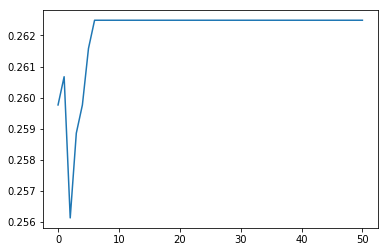

In [28]:
plt.plot(accuracies)
plt.show()

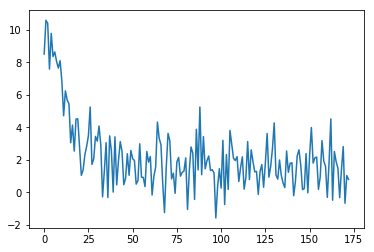

In [29]:
plt.plot(losses)
plt.show()

In [30]:
dev_pos_freqs

Counter()

# Variance reduction

**This is an extra**

We can use a *control variate* to reduce the variance of our gradient estimates.

Let's recap the idea in general terms. We are looking to solve some expectation
\begin{align}
\mu_f = \mathbb E[f(Z)]
\end{align}
but unfortunatelly, realising the full sum (or integral for continuous variables) is intractable. Thus we employ MC estimation
\begin{align}
\hat \mu_f &\overset{\text{MC}}{\approx} \frac{1}{S} \sum_{s=1}^S f(z_s) & \text{where }z_s \sim Q(z|x)
\end{align}
Note that the variance of this estimate is
\begin{align}
\text{Var}(\hat \mu_f) &=  \frac{1}{S}\text{Var}(f(Z)) \\
&= \frac{1}{S} \mathbb E[( f(Z) - \mathbb E[f(Z)])^2]
\end{align}
Note that this variance is such that it goes down as we sample more, in a rate $\mathcal O(S^{-1})$.
See that if we sample $10$ times more, we will only obtain an decrease in variance in the order of $10^{-1}$. This means that sampling more is generally not the most convenient way to decrease variance.

*Digression* we can estimate the variance itself via MC, an unbiased estimate looks like
\begin{align}
\hat \sigma^2_f = \frac{1}{S(S-1)} \sum_{s=1}^S (f(z_s) - \hat \mu_f)^2
\end{align}
but not that this estimate is even hard to improve since it decreases with $\mathcal O(S^{-2})$.

Back to out main problem: let's try and improve the variance of our estimator to $\mu_f$.

It's a fact, and it can be shown trivially, that
\begin{align}
\mu_f &=  \mathbb E[f(Z) - \psi(Z)] + \underbrace{\mathbb E[\psi(Z)]}_{\mu_\psi} \\
 &\overset{\text{MC}}{\approx} \underbrace{\left(\frac{1}{S} \sum_{s=1}^S f(z_s) - \psi(z_s) \right) + \mu_\psi}_{\hat c}
\end{align}
where we assume the existence of some function $\psi(z)$ for which the expected value $\mu_\psi$ is known and we estimate the expected difference $\mathbb E[f(Z) - \psi(Z)]$ via MC. We used this axuxiliary function, also known as a *control variate*, to derive a new estimator, which we will denote by $\hat c$.

The variance of this new estimator is show below:

\begin{align}
\text{Var}( \hat c ) &= \text{Var}(\hat \mu_{f-\psi}) + 2\underbrace{\text{Cov}(\hat \mu_{f-\psi}, \mu_\psi)}_{\mathbb E[\hat \mu_{f-\psi}  \mu_\psi] - \mathbb E[\hat \mu_{f-\psi}] \mathbb E[\mu_\psi]} + \underbrace{\text{Var}(\mu_\psi)}_{\color{blue}{0} } \\
&= \frac{1}{S}\text{Var}(f- \psi)  + 2 \underbrace{\left( \mu_\psi \mu_{f-\psi} - \mu_{f-\psi} \mu_\psi \right)}_{\color{blue}{0}} 
\end{align}
where the variance of $\mu_\psi$ is 0 because we know it in closed form (no need for MC estimation), and the covariance is $0$ as shown in the second row.

That is, the variance of $\hat c$ is essentially the variance of estimating $\mathbb E[f(Z) - \psi(Z)]$, which in turn depends on the variance 

\begin{align}
\text{Var}(f-\psi) &= \text{Var}(f) - 2\text{Cov}(f, \psi) + \text{Var}(\psi)
\end{align}
where we can see that if $\text{Cov}(f, \psi) > \frac{\text{Var}(\psi)}{2}$ we achieve variance reduction as then $\text{Var}(f-\psi)$ would be smaller than $\text{Var(f)}$.




## Baselines

Baslines are control variates of a very simple form:
\begin{align}
\mathbb E[f(Z)] = \mathbb E[f(Z) - C] + \mathbb E[C]
\end{align}
where $C$ is a constant with respect to $z$.

In the context of the score function estimator, a baseline looks like a quantity $C(x; \omega)$, this may be
* just a constant;
* or a function of the input (but not of the latent variable), which could be itself implemented as a neural network;
* a combination of the two.
 

Let's focus on the first term of the ELBO (so I'm omitting the KL term here). The gradient with respect to parameters of the inference model becomes:

\begin{align}
&\mathbb E_{Q(z|x, \lambda)}\left[ \log P(x|z, \theta) \nabla_\lambda \log Q(z|x, \lambda)\right]\\
&=\mathbb E_{Q(z|x, \lambda)}\left[\log P(x|z, \theta) \nabla_\lambda \log Q(z|x, \lambda) - \color{red}{C(x; \omega)\nabla_\lambda \log Q(z|x, \lambda) }  \right] + \underbrace{\mathbb E_{Q(z|x, \lambda)}\left[\color{red}{C(x; \omega)\nabla_\lambda \log Q(z|x, \lambda) }  \right] }_{=0} \\
&= \mathbb E_{Q(z|x, \lambda)}\left[ \color{blue}{\left(\log P(x|z, \theta) - C(x; \omega) \right)}\nabla_\lambda \log Q(z|x, \lambda)\right] \\
&
\end{align}
We can show that the last term is $0$

\begin{align}
&\mathbb E_{Q(z|x, \lambda)}\left[C(x; \omega)\nabla_\lambda \log Q(z|x, \lambda)   \right]  \\&= C(x; \omega) \mathbb E_{Q(z|x, \lambda)}\left[\nabla_\lambda \log Q(z|x, \lambda)   \right]\\
&= C(x; \omega) \mathbb E_{Q(z|x, \lambda)}\left[\frac{1}{Q(z|x, \lambda)} \nabla_\lambda Q(z|x, \lambda)   \right] \\
&= C(x; \omega) \sum_z Q(z|x, \lambda) \frac{1}{Q(z|x, \lambda)} \nabla_\lambda Q(z|x, \lambda)   \\
&= C(x; \omega) \sum_z\nabla_\lambda Q(z|x, \lambda)  \\
&= C(x; \omega) \nabla_\lambda \underbrace{\sum_z Q(z|x, \lambda)  }_{=1}\\
&=0
\end{align}

Examples of useful baselines:

* a running average of the learning signal: at some iteration $t$ we can use a running average of $\log P(x|z, \theta)$ using parameter estimates $\theta$ from iterations $i < t$, this is a baseline that likely leads to high correlation between control variate and learning signal and can lead to variance reduction;
* another technique is to have an MLP with parameters $\omega$ predict a scalar and train this MLP to approximate the learning signal $\log P(x|z, \theta)$ via regression:
\begin{align}
\arg\max_\omega \left( C(x; \omega) - \log P(x|z, \theta) \right)^2
\end{align}
its left as an extra to implement these ideas.

One more note: we can also use something called a *multiplicative baseline* in the literature of reinforcement learning, whereby we incorporate a running estimate of the standard deviation of the learning signal computed based on the values attained on previous iterations:
\begin{align}
\mathbb E_{Q(z|x, \lambda)}\left[ \frac{1}{\hat\sigma_{\text{past}}}\left(\log P(x|z, \theta) - \hat \mu_{\text{past}}\right)\nabla_\lambda \log Q(z|x, \lambda)\right]
\end{align}
this form of contorl variate aim at promoting the learning signal (or reward in reinforcement learning literature) to be distributed by $\mathcal N(0, 1)$. Note that multiplying the reward by a constant does not bias the estimator, and in this case, may lead to variance reduction.